<a href="https://colab.research.google.com/github/MahdiNouraie/CNN-FashionMNIST/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot

In [ ]:
transform = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5,) , (0.5,) , )])

In [ ]:
trainset = datasets.FashionMNIST('~/ .pytorch/F_MNIST_data' , download= True , transform= transform , train= True)
testset = datasets.FashionMNIST('~/ .pytorch/F_MNIST_data' , download= True , transform= transform , train= False)

In [ ]:
trainset[0][0].shape

torch.Size([1, 28, 28])

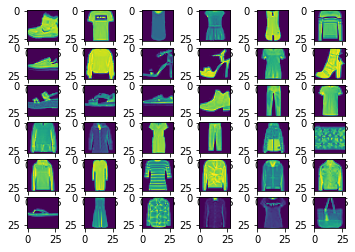

In [ ]:
for i in range(36):
	pyplot.subplot(6, 6, i+1)
	pyplot.imshow(trainset[i][0].squeeze(0))
pyplot.show()

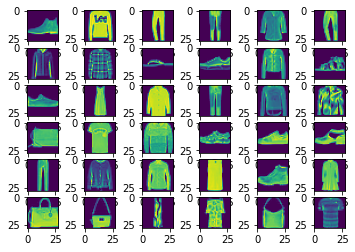

In [ ]:
for i in range(36):
	pyplot.subplot(6, 6, i+1)
	pyplot.imshow(testset[i][0].squeeze(0))
pyplot.show()

In [ ]:
V = []
for i in range(len(trainset)):
  V.append(trainset[i][1])

list(set(V))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
train_dl = DataLoader(trainset, batch_size=64, shuffle=True)
val_dl = DataLoader(testset, batch_size=1024, shuffle=False)

In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device) , labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device) , labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ClothesClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1,  padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(256*3*3,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
num_epochs = 100
lr = 0.001
opt_func = torch.optim.Adam
model = ClothesClassification()
model.to(device)
history = fit(num_epochs , lr , model , train_dl , val_dl)

Epoch [0], train_loss: 2.3029, val_loss: 2.3029, val_acc: 0.1002
Epoch [1], train_loss: 2.3028, val_loss: 2.3028, val_acc: 0.1002
Epoch [2], train_loss: 2.3028, val_loss: 2.3027, val_acc: 0.1002
Epoch [3], train_loss: 2.3027, val_loss: 2.3027, val_acc: 0.1002
Epoch [4], train_loss: 2.3027, val_loss: 2.3026, val_acc: 0.1002
Epoch [5], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1002
Epoch [6], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1002
Epoch [7], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1002
Epoch [8], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1002
Epoch [9], train_loss: 2.3026, val_loss: 2.3025, val_acc: 0.1002
Epoch [10], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1002
Epoch [11], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1002
Epoch [12], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1002
Epoch [13], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1002
Epoch [14], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1002
Epoch [15], train_lo

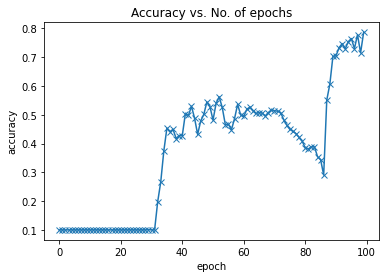

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    pyplot.plot(accuracies, '-x')
    pyplot.xlabel('epoch')
    pyplot.ylabel('accuracy')
    pyplot.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)


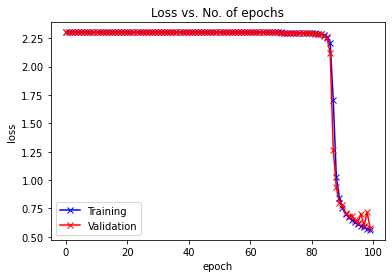

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    pyplot.plot(train_losses, '-bx')
    pyplot.plot(val_losses, '-rx')
    pyplot.xlabel('epoch')
    pyplot.ylabel('loss')
    pyplot.legend(['Training', 'Validation'])
    pyplot.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
num_epochs = 200
lr = 0.001
opt_func = torch.optim.Adam
model = ClothesClassification()
model.to(device)
history = fit(num_epochs , lr , model , train_dl , val_dl)

Epoch [0], train_loss: 2.3034, val_loss: 2.3033, val_acc: 0.1001
Epoch [1], train_loss: 2.3032, val_loss: 2.3031, val_acc: 0.1001
Epoch [2], train_loss: 2.3031, val_loss: 2.3030, val_acc: 0.1001
Epoch [3], train_loss: 2.3030, val_loss: 2.3029, val_acc: 0.1001
Epoch [4], train_loss: 2.3029, val_loss: 2.3028, val_acc: 0.1001
Epoch [5], train_loss: 2.3028, val_loss: 2.3028, val_acc: 0.1001
Epoch [6], train_loss: 2.3027, val_loss: 2.3027, val_acc: 0.1001
Epoch [7], train_loss: 2.3027, val_loss: 2.3027, val_acc: 0.1001
Epoch [8], train_loss: 2.3027, val_loss: 2.3027, val_acc: 0.1001
Epoch [9], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1001
Epoch [10], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1001
Epoch [11], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1001
Epoch [12], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1001
Epoch [13], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1001
Epoch [14], train_loss: 2.3026, val_loss: 2.3025, val_acc: 0.1001
Epoch [15], train_lo

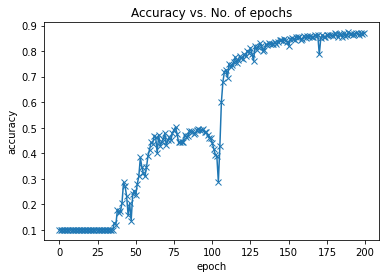

In [ ]:
plot_accuracies(history)

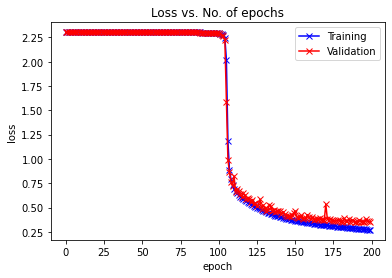

In [ ]:
plot_losses(history)